# Interest rate modeling using CIR - DAI vs WETH 

### The strategy exemplified here is: lend DAI, borrow WETH


**Data: BRC (2020-2022), will get more from thegraph.com.**

**The point here is that $\theta$ spread [$\theta$ from CIR (mean to which the interest rates revert to)] has to be greater than the volatility drag, unless our assets have really low or even negative correlation or low volatility. Otherwise we don't earn anything from the APY spread of the two tokens**

We could look into tokens with low correlation or less volatile


I'm looking into how we should deal with correlation and tail risk

I think we should also consider rebalancing, static portfolio might be unrealistic

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from log_health import HealthProcessParameters
from pathlib import Path
from IPython.display import display

In [54]:
def find_repo_root(start: Path = None) -> Path:
    p = Path.cwd() if start is None else Path(start)
    for d in [p] + list(p.parents):
        if (d / 'pyproject.toml').exists() or (d / '.git').exists():
            return d
    return p
repo_root = find_repo_root()
plots_dir = repo_root / 'results' / 'plots'

In [55]:
# Ensure Path.cwd() returns the repo root so later cells don't accidentally use src as root
_repo_root = find_repo_root()
Path.cwd = classmethod(lambda cls: _repo_root)
repo_root = _repo_root
plots_dir = repo_root / 'results' / 'plots'

**Supply & Variable Borrow Rate Visualizations & descriptive stats**


Loaded DAI.csv: (14467, 19)


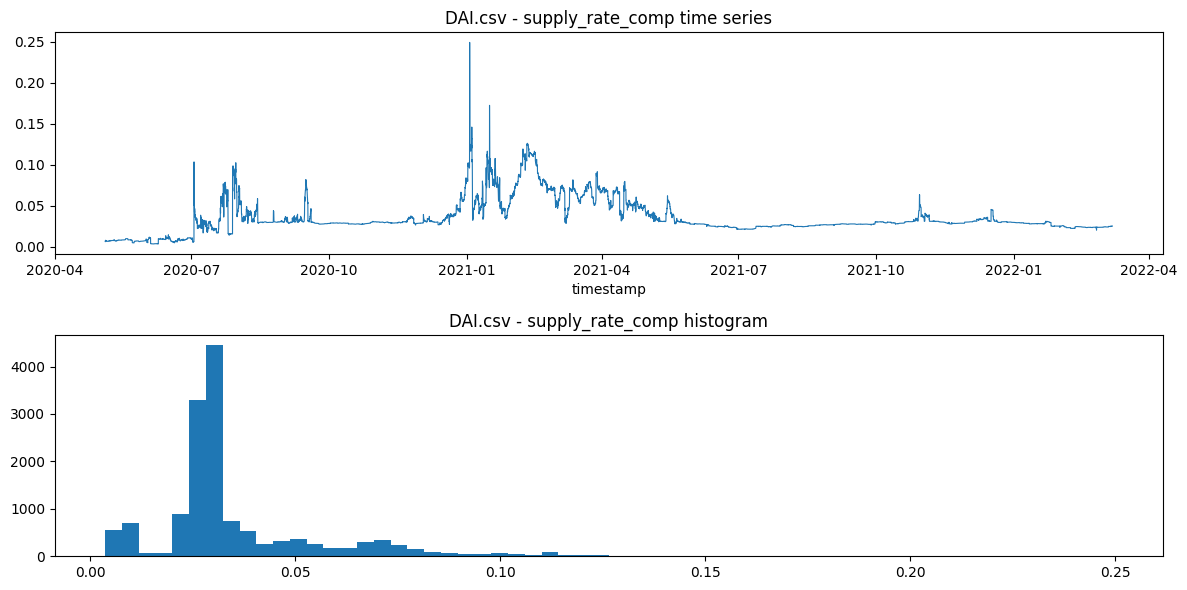

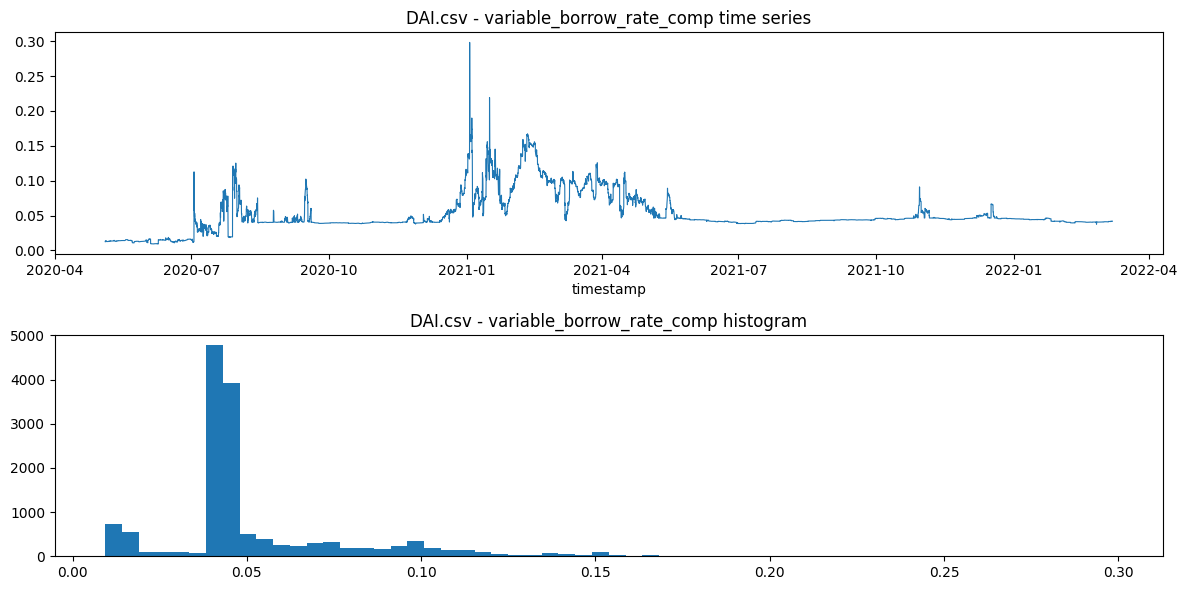


Summary for DAI.csv
                             count      mean    median       std       min  \
supply_rate_comp           14465.0  0.035490  0.029531  0.020689  0.003713   
variable_borrow_rate_comp  14465.0  0.051393  0.043850  0.027096  0.009355   

                                max  
supply_rate_comp           0.249272  
variable_borrow_rate_comp  0.298313  

Loaded WETH.csv: (14467, 19)


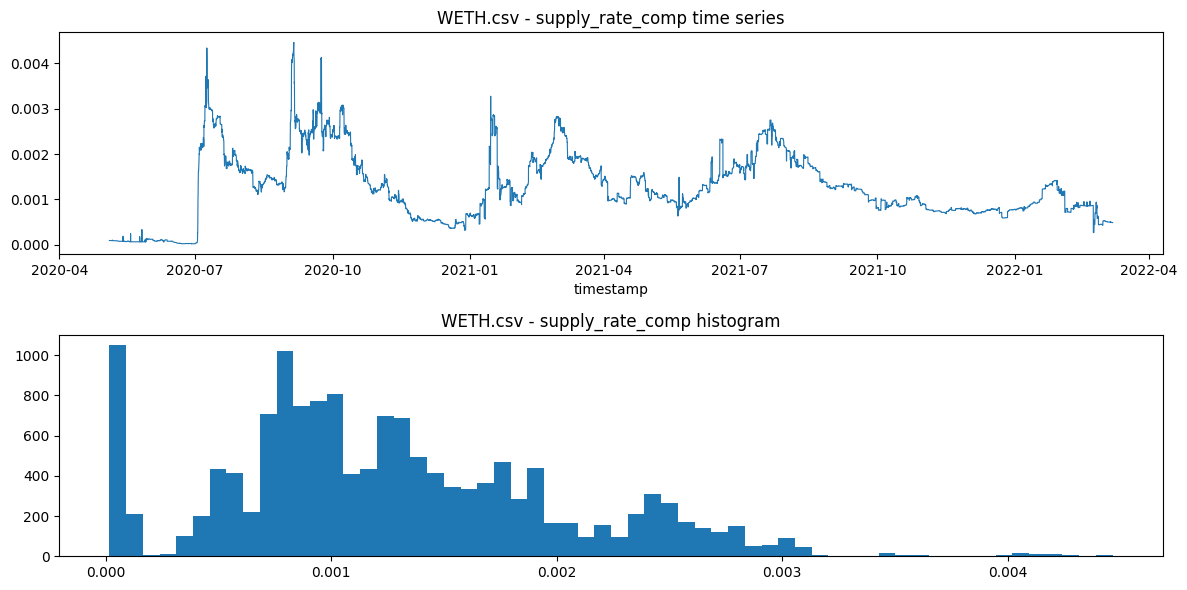

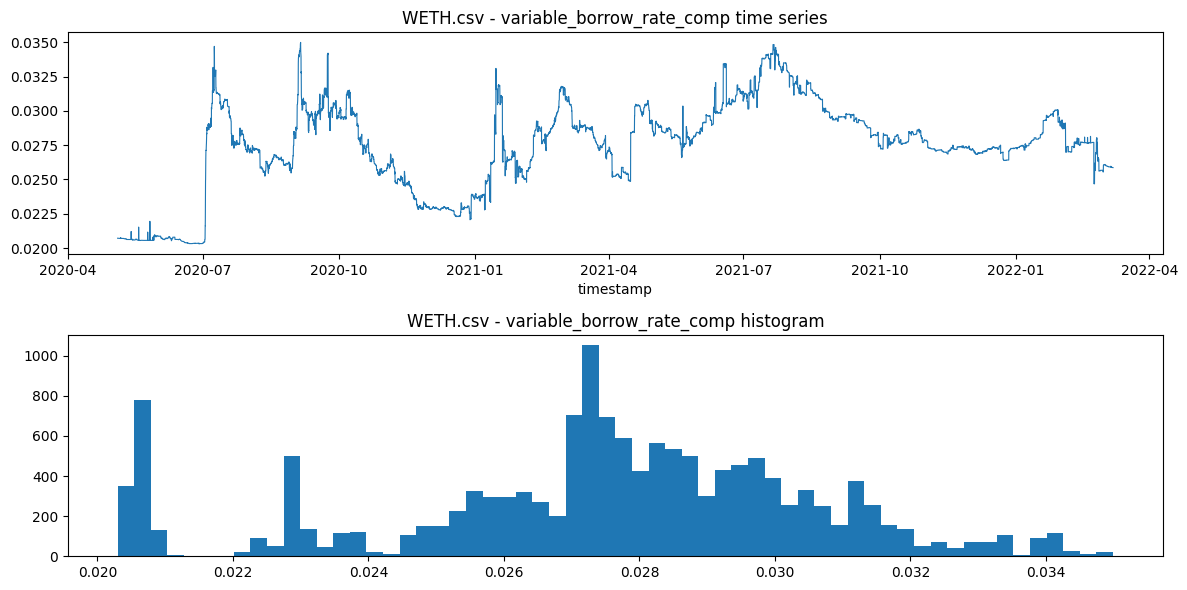


Summary for WETH.csv
                             count      mean    median       std       min  \
supply_rate_comp           14465.0  0.001259  0.001153  0.000741  0.000017   
variable_borrow_rate_comp  14465.0  0.027406  0.027655  0.003204  0.020297   

                                max  
supply_rate_comp           0.004465  
variable_borrow_rate_comp  0.034990  


In [56]:
data_dir = repo_root / 'data' / 'raw'
files = ['DAI.csv','WETH.csv']
for fn in files:
    fp = str(data_dir / fn)
    df = pd.read_csv(fp, parse_dates=['timestamp'])
    print(f'\nLoaded {fn}:', df.shape)
    for col in ['supply_rate_comp','variable_borrow_rate_comp']:
        if col not in df.columns:
            print(f'{fn}: column {col} not found')
            continue
        s = pd.to_numeric(df[col], errors='coerce')
        fig, ax = plt.subplots(2,1,figsize=(12,6))
        # transparent background
        fig.patch.set_facecolor('none')
        ax[0].set_facecolor('none')
        ax[1].set_facecolor('none')
        x = df['timestamp'] if 'timestamp' in df.columns else df.index
        ax[0].plot(x, s, lw=0.8)
        ax[0].set_title(f'{fn} - {col} time series')
        ax[0].set_xlabel('timestamp')
        ax[0].grid(False)
        ax[1].hist(s.dropna(), bins=60)
        ax[1].set_title(f'{fn} - {col} histogram')
        ax[1].grid(False)
        plt.tight_layout()
        plt.show()
    summary = {}
    for col in ['supply_rate_comp','variable_borrow_rate_comp']:
        if col in df.columns:
            s = pd.to_numeric(df[col], errors='coerce').dropna()
            summary[col] = {'count':int(s.count()), 'mean':float(s.mean()), 'median':float(s.median()), 'std':float(s.std()), 'min':float(s.min()), 'max':float(s.max())}
    print('\nSummary for', fn)
    print(pd.DataFrame(summary).T.round(6))


**CIR estimation for DAI supply rate and WETH borrow rate (separate models)**

The cells below estimate CIR models separately for:
- DAI `supply_rate_comp` 
- WETH `variable_borrow_rate_comp`

Fitting both the Euler/GMM-style estimator and the exact MLE (non-central chi-square transition) implemented in `src/cir_model.py` for the full sample and for three periods: Jun 2020–Dec 2020, May 2021, and Dec 2021–Feb 2022.

**I chose these periods because they seemed to have some patterns (i.e bull bear stable)**

In [57]:
import sys
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robustly import cir_model: reload if present, otherwise load from source file
import importlib, importlib.util
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)

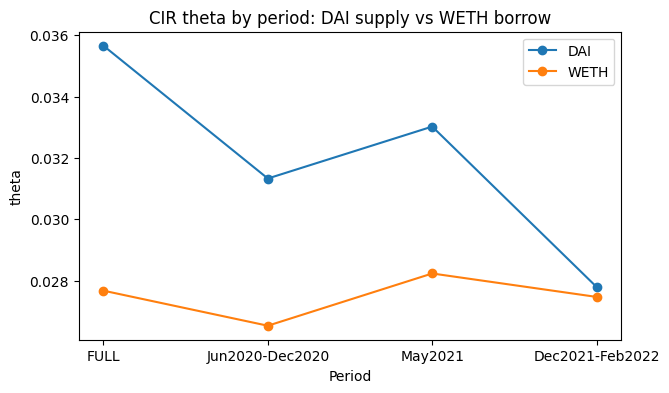

In [58]:
# Plot CIR theta by period for DAI supply vs WETH borrow
repo_root = Path.cwd()
fp = repo_root / 'results' / 'cir_dai_weth_separate.csv'
if not fp.exists():
    print('No cir_dai_weth_separate.csv found at', fp)
else:
    df = pd.read_csv(fp)
    # choose theta: prefer MLE theta when available and successful, else Euler theta
    def pick_theta(row):
        if 'm_theta' in row.index and pd.notna(row['m_theta']) and ('m_success' not in row.index or row.get('m_success', True)):
            return row['m_theta']
        if 'e_theta' in row.index and pd.notna(row['e_theta']):
            return row['e_theta']
        return float('nan')
    df['theta'] = df.apply(pick_theta, axis=1)
    periods_order = ['FULL','Jun2020-Dec2020','May2021','Dec2021-Feb2022']
    plt.figure(figsize=(7,4))
    for asset in df['asset'].unique():
        sub = df[df['asset']==asset].set_index('period').reindex(periods_order)
        plt.plot(periods_order, sub['theta'].values, marker='o', label=asset)
    plt.xlabel('Period')
    plt.ylabel('theta')
    plt.title('CIR theta by period: DAI supply vs WETH borrow')
    plt.legend()
    plt.grid(False)
    outp = repo_root / 'results' / 'plots' / 'cir_theta_dai_weth_separate.png'
    outp.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outp, bbox_inches='tight', transparent=True)
    plt.show()

In [59]:
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robust import of cir_model
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)
# data files  
fp_dai = repo_root / 'data' / 'raw' / 'DAI.csv'
fp_weth = repo_root / 'data' / 'raw' / 'WETH.csv'
out_dir = repo_root / 'results'
out_dir.mkdir(parents=True, exist_ok=True)
rows = []
if not fp_dai.exists() or not fp_weth.exists():
    print('Missing input CSVs at', fp_dai, fp_weth)
else:
    df_d = pd.read_csv(fp_dai, parse_dates=['timestamp']).set_index('timestamp')
    df_w = pd.read_csv(fp_weth, parse_dates=['timestamp']).set_index('timestamp')
    if 'supply_rate_comp' not in df_d.columns or 'variable_borrow_rate_comp' not in df_w.columns:
        print('Required columns missing in inputs')
    else:
        series_defs = { 'DAI_supply': (df_d['supply_rate_comp'], 'DAI'), 'WETH_borrow': (df_w['variable_borrow_rate_comp'], 'WETH') }
        periods = { 'FULL': (None, None), 'Jun2020-Dec2020': ('2020-06-01','2020-12-31'), 'May2021': ('2021-05-01','2021-05-31'), 'Dec2021-Feb2022': ('2021-12-01','2022-02-28') }
        def infer_dt(idx):
            if not isinstance(idx, pd.DatetimeIndex) or len(idx) < 2:
                return 1.0/365.0
            median_sec = idx.to_series().diff().dt.total_seconds().median()
            if pd.isna(median_sec) or median_sec <= 0:
                return 1.0/365.0
            return float(median_sec) / (3600*24*365)
        for name, (ser, asset_label) in series_defs.items():
            s = pd.to_numeric(ser, errors='coerce').dropna()
            for pname, (start, end) in periods.items():
                if pname == 'FULL':
                    sub = s
                else:
                    sub = s.loc[start:end] if isinstance(s.index, pd.DatetimeIndex) else s
                if sub.empty:
                    rows.append({'series':name, 'asset':asset_label, 'period':pname, 'n':0})
                    continue
                dt = infer_dt(sub.index)
                try:
                    efit = cir_model.fit_cir_euler(sub.values, dt)
                except Exception as ex:
                    efit = None
                    print('Euler fit error', name, pname, ex)
                try:
                    mfit = cir_model.fit_cir_mle(sub.values, dt)
                except Exception as ex:
                    mfit = None
                    print('MLE fit error', name, pname, ex)
                row = dict(series=name, asset=asset_label, period=pname, n=len(sub), dt=dt)
                if efit:
                    row.update({'e_kappa':efit.get('kappa'), 'e_theta':efit.get('theta'), 'e_sigma':efit.get('sigma')})
                if mfit:
                    row.update({'m_kappa':mfit.get('kappa'), 'm_theta':mfit.get('theta'), 'm_sigma':mfit.get('sigma'), 'm_success':mfit.get('success')})
                rows.append(row)
        out_df = pd.DataFrame(rows)
        out_fp = out_dir / 'cir_dai_weth_separate.csv'
        out_df.to_csv(out_fp, index=False)
        display(out_df.round(6))

,series,asset,period,n,dt,e_kappa,e_theta,e_sigma,m_kappa,m_theta,m_sigma,m_success
0,DAI_supply,DAI,FULL,14465,0.000127,61.688084,0.035657,1.212802,61.688084,0.035657,1.212802,True
1,DAI_supply,DAI,Jun2020-Dec2020,4628,0.000127,123.816900,0.031332,1.369637,123.816900,0.031332,1.369637,True
2,DAI_supply,DAI,May2021,666,0.000127,91.710116,0.033023,0.502543,91.710116,0.033023,0.502543,True
3,DAI_supply,DAI,Dec2021-Feb2022,1933,0.000127,47.999584,0.027798,0.234592,47.999584,0.027798,0.234592,True
4,WETH_borrow,WETH,FULL,14465,0.000127,10.299763,0.027678,0.082877,10.299763,0.027678,0.082877,True
5,WETH_borrow,WETH,Jun2020-Dec2020,4628,0.000127,8.468340,0.026536,0.081393,8.468340,0.026536,0.081393,True
6,WETH_borrow,WETH,May2021,666,0.000127,536.512988,0.028238,0.094517,536.512987,0.028238,0.097031,True
7,WETH_borrow,WETH,Dec2021-Feb2022,1933,0.000127,45.549280,0.027473,0.061621,45.549280,0.027474,0.062478,True


In [60]:
# Volatility Drag: σ_h² = var(ln(DAI) - ln(ETH))
repo_root = find_repo_root()

# Try to read from saved diffusion params summary
summary_fp = repo_root / 'results' / 'diffusion_params_summary.txt'
if summary_fp.exists():
    print("Reading volatility drag from saved diffusion params...")
    vals = {}
    for ln in summary_fp.read_text().splitlines():
        if '=' in ln:
            k, v = ln.split('=', 1)
            try:
                vals[k.strip()] = float(v.strip())
            except Exception:
                vals[k.strip()] = v.strip()
    
    sigma_dai = vals.get('sigma_dai_annual', float('nan'))
    sigma_weth = vals.get('sigma_weth_annual', float('nan')) 
    rho = vals.get('rho_non_jump', float('nan'))
    sigma_h2 = vals.get('sigma_h2', float('nan'))
    
    print(f"Annual volatilities:")
    print(f"  σ_DAI = {sigma_dai:.6f}")
    print(f"  σ_WETH = {sigma_weth:.6f}")
    print(f"  ρ (correlation) = {rho:.6f}")
    print(f"\nVolatility Drag (σ_h²):")
    print(f"  σ_h² = σ_WETH² + σ_DAI² - 2ρσ_WETH σ_DAI")
    print(f"  σ_h² = {sigma_weth:.6f}² + {sigma_dai:.6f}² - 2×{rho:.6f}×{sigma_weth:.6f}×{sigma_dai:.6f}")
    print(f"  σ_h² = {sigma_h2:.6f}")
    
else:
    print("Computing volatility drag from log returns...")
    
    # Load log returns
    ret_dir = repo_root / 'results' / 'returns'
    files = {'DAI': ret_dir / 'DAI_daily_log_returns.csv', 'WETH': ret_dir / 'WETH_daily_log_returns.csv'}
    
    rets = {}
    for asset, fp in files.items():
        if fp.exists():
            df = pd.read_csv(fp, index_col=0, parse_dates=True)
            col = 'log_return' if 'log_return' in df.columns else df.columns[0]
            r = df[col].dropna()
            rets[asset] = r
        else:
            print(f"Warning: {asset} returns not found at {fp}")
    
    if 'DAI' in rets and 'WETH' in rets:
        # Filter out jumps using 1%/99% quantiles
        q_low, q_high = 0.01, 0.99
        non_jump = {}
        
        for asset, r in rets.items():
            low = r.quantile(q_low)
            high = r.quantile(q_high)
            nj = r[(r >= low) & (r <= high)].dropna()
            non_jump[asset] = nj
        
        # Align and compute correlation
        aligned = pd.concat([non_jump['DAI'].rename('DAI'), non_jump['WETH'].rename('WETH')], axis=1).dropna()
        
        if not aligned.empty:
            # Daily volatilities
            sigma_dai_daily = float(aligned['DAI'].std())
            sigma_weth_daily = float(aligned['WETH'].std())
            
            # Annualized volatilities
            sigma_dai = sigma_dai_daily * np.sqrt(365.25)
            sigma_weth = sigma_weth_daily * np.sqrt(365.25)
            
            # Correlation
            rho = float(aligned['DAI'].corr(aligned['WETH']))
            
            # Volatility drag
            sigma_h2 = sigma_weth**2 + sigma_dai**2 - 2.0 * rho * sigma_weth * sigma_dai
            
            print(f"Annual volatilities:")
            print(f"  σ_DAI = {sigma_dai:.6f}")
            print(f"  σ_WETH = {sigma_weth:.6f}")
            print(f"  ρ (correlation) = {rho:.6f}")
            print(f"\nVolatility Drag (σ_h²):")
            print(f"  σ_h² = σ_WETH² + σ_DAI² - 2ρσ_WETH σ_DAI")
            print(f"  σ_h² = {sigma_weth:.6f}² + {sigma_dai:.6f}² - 2×{rho:.6f}×{sigma_weth:.6f}×{sigma_dai:.6f}")
            print(f"  σ_h² = {sigma_h2:.6f}")
        else:
            print("Error: No aligned non-jump returns found")
            sigma_h2 = float('nan')
    else:
        print("Error: Missing DAI or WETH log returns data")
        sigma_h2 = float('nan')

# Calculate μ_h using θ_DAI - θ_WETH as the drift component from interest rates
print("\n" + "="*60)
print("DRIFT CALCULATION: μ_h = (θ_DAI - θ_WETH) - 0.5 * σ_h²")
print("="*60)

if not np.isnan(sigma_h2):
    # Load separate DAI and WETH CIR results
    separate_fp = repo_root / 'results' / 'cir_dai_weth_separate.csv'
    if separate_fp.exists():
        df_sep = pd.read_csv(separate_fp)
        
        print(f"\nUsing σ_h² = {sigma_h2:.6f}")
        print(f"Half variance term: 0.5 * σ_h² = {0.5 * sigma_h2:.6f}")
        print("\nDrift calculations by period:")
        
        # Get unique periods
        periods = df_sep['period'].unique()
        
        for period in periods:
            df_period = df_sep[df_sep['period'] == period]
            
            # Get DAI theta
            dai_row = df_period[df_period['asset'] == 'DAI']
            weth_row = df_period[df_period['asset'] == 'WETH']
            
            theta_dai = None
            theta_weth = None
            dai_method = None
            weth_method = None
            
            if not dai_row.empty:
                row = dai_row.iloc[0]
                if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                    theta_dai = row['m_theta']
                    dai_method = "MLE"
                elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                    theta_dai = row['e_theta']
                    dai_method = "Euler"
                    
            if not weth_row.empty:
                row = weth_row.iloc[0]
                if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                    theta_weth = row['m_theta']
                    weth_method = "MLE"
                elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                    theta_weth = row['e_theta']
                    weth_method = "Euler"
            
            if theta_dai is not None and theta_weth is not None:
                theta_spread = theta_dai - theta_weth
                mu_h = theta_spread - 0.5 * sigma_h2
                print(f"  {period:15s}: θ_DAI={theta_dai:.6f} ({dai_method}), θ_WETH={theta_weth:.6f} ({weth_method})")
                print(f"                   θ_spread={theta_spread:.6f} → μ_h = {mu_h:.6f}")
            else:
                print(f"  {period:15s}: Missing theta estimates (DAI: {theta_dai}, WETH: {theta_weth})")
                
    else:
        print(f"Separate CIR results not found at {separate_fp}")
        print("Run the CIR fitting cell first to generate cir_dai_weth_separate.csv")
else:
    print("Cannot calculate μ_h: σ_h² is not available")

Reading volatility drag from saved diffusion params...
Annual volatilities:
  σ_DAI = 0.060245
  σ_WETH = 0.821698
  ρ (correlation) = 0.057271

Volatility Drag (σ_h²):
  σ_h² = σ_WETH² + σ_DAI² - 2ρσ_WETH σ_DAI
  σ_h² = 0.821698² + 0.060245² - 2×0.057271×0.821698×0.060245
  σ_h² = 0.673147

DRIFT CALCULATION: μ_h = (θ_DAI - θ_WETH) - 0.5 * σ_h²

Using σ_h² = 0.673147
Half variance term: 0.5 * σ_h² = 0.336574

Drift calculations by period:
  FULL           : θ_DAI=0.035657 (MLE), θ_WETH=0.027678 (MLE)
                   θ_spread=0.007979 → μ_h = -0.328594
  Jun2020-Dec2020: θ_DAI=0.031332 (MLE), θ_WETH=0.026536 (MLE)
                   θ_spread=0.004796 → μ_h = -0.331778
  May2021        : θ_DAI=0.033023 (MLE), θ_WETH=0.028238 (MLE)
                   θ_spread=0.004786 → μ_h = -0.331788
  Dec2021-Feb2022: θ_DAI=0.027798 (MLE), θ_WETH=0.027474 (MLE)
                   θ_spread=0.000324 → μ_h = -0.336250


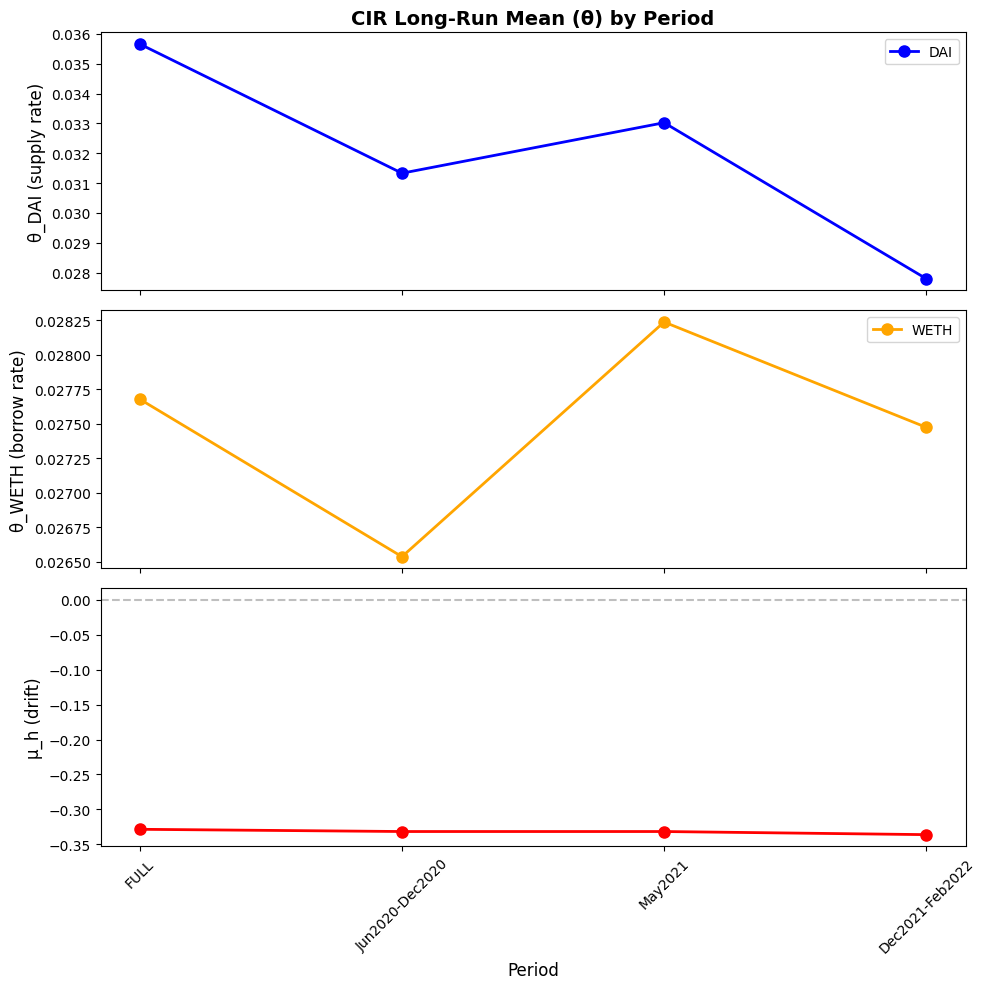


Summary table (σ_h² = 0.673147):
Period          θ_DAI      θ_WETH     θ_spread   μ_h       
------------------------------------------------------------
FULL            0.035657   0.027678   0.007979   -0.328594 
Jun2020-Dec2020 0.031332   0.026536   0.004796   -0.331778 
May2021         0.033023   0.028238   0.004786   -0.331788 
Dec2021-Feb2022 0.027798   0.027474   0.000324   -0.336250 


In [61]:
# Plot CIR parameters (theta) for DAI and WETH by period
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

repo_root = find_repo_root()
separate_fp = repo_root / 'results' / 'cir_dai_weth_separate.csv'

if separate_fp.exists() and not np.isnan(sigma_h2):
    df_sep = pd.read_csv(separate_fp)
    
    # Get unique periods
    periods = list(df_sep['period'].unique())
    
    dai_thetas = []
    weth_thetas = []
    mu_h_values = []
    
    for period in periods:
        df_period = df_sep[df_sep['period'] == period]
        
        dai_row = df_period[df_period['asset'] == 'DAI']
        weth_row = df_period[df_period['asset'] == 'WETH']
        
        theta_dai = None
        theta_weth = None
        
        if not dai_row.empty:
            row = dai_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_dai = row['m_theta']
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_dai = row['e_theta']
                
        if not weth_row.empty:
            row = weth_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_weth = row['m_theta']
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_weth = row['e_theta']
        
        dai_thetas.append(theta_dai if theta_dai is not None else np.nan)
        weth_thetas.append(theta_weth if theta_weth is not None else np.nan)
        
        if theta_dai is not None and theta_weth is not None:
            theta_spread = theta_dai - theta_weth
            mu_h = theta_spread - 0.5 * sigma_h2
            mu_h_values.append(mu_h)
        else:
            mu_h_values.append(np.nan)
    
    # Create the plot
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    
    # Plot DAI theta
    axes[0].plot(periods, dai_thetas, 'o-', color='blue', linewidth=2, markersize=8, label='DAI')
    axes[0].set_ylabel('θ_DAI (supply rate)', fontsize=12)
    axes[0].set_title('CIR Long-Run Mean (θ) by Period', fontsize=14, fontweight='bold')
    axes[0].grid(False)
    axes[0].set_facecolor('none')
    axes[0].legend()
    
    # Plot WETH theta
    axes[1].plot(periods, weth_thetas, 'o-', color='orange', linewidth=2, markersize=8, label='WETH')
    axes[1].set_ylabel('θ_WETH (borrow rate)', fontsize=12)
    axes[1].grid(False)
    axes[1].set_facecolor('none')
    axes[1].legend()
    
    # Plot mu_h = (θ_DAI - θ_WETH) - 0.5 * σ_h²
    axes[2].plot(periods, mu_h_values, 'o-', color='red', linewidth=2, markersize=8)
    axes[2].set_ylabel('μ_h (drift)', fontsize=12)
    axes[2].set_xlabel('Period', fontsize=12)
    axes[2].grid(False)
    axes[2].set_facecolor('none')
    axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Format x-axis
    plt.xticks(rotation=45)
    
    # Set transparent background
    fig.patch.set_facecolor('none')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"\nSummary table (σ_h² = {sigma_h2:.6f}):")
    print(f"{'Period':<15} {'θ_DAI':<10} {'θ_WETH':<10} {'θ_spread':<10} {'μ_h':<10}")
    print("-" * 60)
    for period, t_dai, t_weth, mu_h in zip(periods, dai_thetas, weth_thetas, mu_h_values):
        t_spread = t_dai - t_weth if not (np.isnan(t_dai) or np.isnan(t_weth)) else np.nan
        print(f"{period:<15} {t_dai:<10.6f} {t_weth:<10.6f} {t_spread:<10.6f} {mu_h:<10.6f}")
        
else:
    if not separate_fp.exists():
        print(f"Separate CIR results not found at {separate_fp}")
        print("Run the CIR fitting cell first.")
    if np.isnan(sigma_h2):
        print("σ_h² not available. Run the volatility drag cell first.")